# CI-PROJECT2

## PHASE1

In [47]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import numpy
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [49]:
def crop_plate_from_xml(xml_path, images_dir, output_dir, original_size=(224, 224), target_size=(1280, 1280)):
    try:
        scale_x = target_size[0] / original_size[0]
        scale_y = target_size[1] / original_size[1]

        base_filename = os.path.splitext(os.path.basename(xml_path))[0]
        image_filename = f"{base_filename}.png"
        image_path = os.path.join(images_dir, image_filename)

        if not os.path.exists(image_path):
            print(f"[ERROR] Image not found: {image_path}")
            return

        try:
            image = Image.open(image_path)
        except UnidentifiedImageError:
            print(f"[ERROR] Cannot open image: {image_path}")
            return

        tree = ET.parse(xml_path)
        root = tree.getroot()

        bndbox = root.find('.//bndbox')
        if bndbox is None:
            print(f"[WARN] No <bndbox> found in: {xml_path}")
            return

        try:
            xmin = int(float(bndbox.find('xmin').text) * scale_x)
            ymin = int(float(bndbox.find('ymin').text) * scale_y)
            xmax = int(float(bndbox.find('xmax').text) * scale_x)
            ymax = int(float(bndbox.find('ymax').text) * scale_y)
        except (AttributeError, ValueError) as e:
            print(f"[ERROR] Invalid bounding box in XML: {xml_path} — {e}")
            return

        cropped = image.crop((xmin, ymin, xmax, ymax))

        save_path = os.path.join(output_dir, image_filename)
        cropped.save(save_path)

    except ET.ParseError as e:
        print(f"[ERROR] XML parse error: {xml_path} — {e}")
    except Exception as e:
        print(f"[FATAL] Unexpected error: {xml_path} — {e}")


In [51]:
current_dir = os.getcwd()
test_dir = os.path.join(current_dir, "test-dataset")
annotation_dir = os.path.join(test_dir, "Vehicle Plates annotations", "Vehicle Plates annotations")
plate_dir = os.path.join(test_dir, "Vehicle Plates 1280x1280", "Vehicle Plates 1280x1280")
output_dir = os.path.join(current_dir, "cropped-annotation")

for xml_file in os.listdir(annotation_dir):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(annotation_dir, xml_file)
        crop_plate_from_xml(
            xml_path=xml_path,
            images_dir=plate_dir,
            output_dir=output_dir
        )

## PHASE1 - extra score

In [53]:
def load_image(path):
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"Image not found at: {path}")
    return image

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def apply_gaussian_blur(image, kernel_size=(3, 3), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def enhance_contrast_clahe(gray_img, clipLimit=2.0, tileGridSize=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    return clahe.apply(gray_img)

def linear_contrast_stretch(gray_img, low_percentile=5, high_percentile=95):
    # Compute thresholds
    low = np.percentile(gray_img, low_percentile)
    high = np.percentile(gray_img, high_percentile)
    # Clip and normalize
    stretched = np.clip(gray_img, low, high)
    return cv2.normalize(stretched, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def detect_edges(image, low_threshold=50, high_threshold=100):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges

def apply_morphology(edges, kernel_size=(5, 5), iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return closed

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def find_plate_candidates(
    image, 
    aspect_ratio_range=(2, 6), 
    use_dynamic_area=False, 
    min_area_limit=1000, 
    max_area_limit=10000  # or adjust based on image size/resolution
):
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(image, kernel, iterations=1)

    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []

    areas = [cv2.boundingRect(cnt)[2] * cv2.boundingRect(cnt)[3] for cnt in contours]
    if not areas:
        return []

    # Dynamically scale min_area using median if desired
    median_area = np.median(areas)
    dynamic_min_area = median_area * 0.5 if use_dynamic_area else min_area_limit

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        area = w * h

        # Must be within min and max area range, and correct aspect ratio
        if (
            dynamic_min_area <= area <= max_area_limit
            and aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]
        ):
            candidates.append((x, y, w, h))

    return candidates

def draw_candidates(image, candidates, color=(255, 0, 0), thickness=2):
    img_copy = image.copy()
    for (x, y, w, h) in candidates:
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, thickness)
    return img_copy

def extract_plate_region(image, candidate, apply_blur=True, blur_kernel=(7, 7)):
    x, y, w, h = candidate
    region = image[y:y+h, x:x+w]

    if apply_blur:
        region = cv2.GaussianBlur(region, blur_kernel, 0)
    
    return region

def plot_plate_only(plate_img, title="Detected Plate"):
    plate_rgb = cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB)
    return plate_rgb


def get_centered_candidate(candidates, image_shape=(224, 244)):
    if not candidates:
        return None
    
    img_h, img_w = image_shape[:2]
    img_center = (img_w / 2, img_h / 2)

    def distance_from_center(candidate):
        x, y, w, h = candidate
        cx = x + w / 2
        cy = y + h / 2
        dx = cx - img_center[0]
        dy = cy - img_center[1]
        return dx**2 + dy**2  # squared Euclidean distance

    return min(candidates, key=distance_from_center)

def draw_candidate_box(image, candidate, color=(0, 255, 0), thickness=2):
    image_copy = image.copy()
    if candidate:
        x, y, w, h = candidate
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), color, thickness)
    return image_copy

def plot_two_images(img1, img2, title1="Original", title2="Processed"):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title(title1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [54]:
current_dir = os.getcwd()
dataset_dir = os.path.join(current_dir, "learn-dataset")
test_dir = os.path.join(current_dir, "test-dataset")
test_dir = os.path.join(test_dir, "Vehicle Plates", "Vehicle Plates")
image_path = os.path.join(test_dir, "3.png")

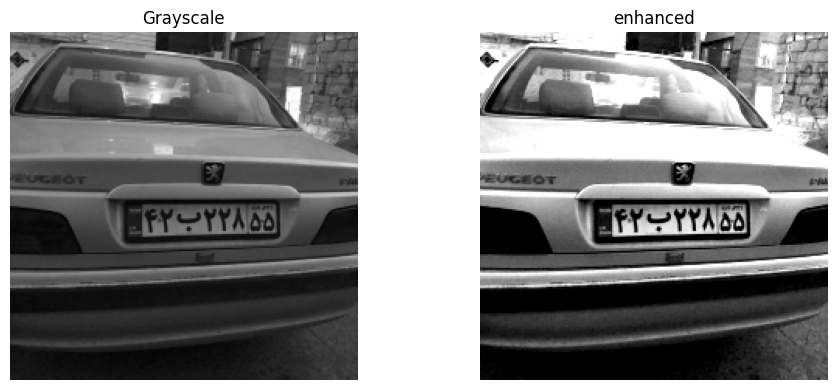

In [55]:
original = load_image(image_path)
gray = to_grayscale(original)
enhanced = linear_contrast_stretch(gray , low_percentile=15, high_percentile=85)
plot_two_images(gray, enhanced, "Grayscale", "enhanced")

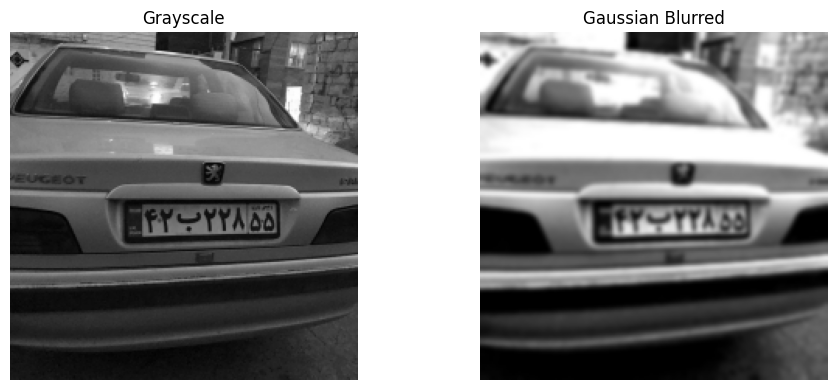

In [56]:
blurred = apply_gaussian_blur(enhanced, (7,7), 0)
plot_two_images(gray, blurred, "Grayscale", "Gaussian Blurred")

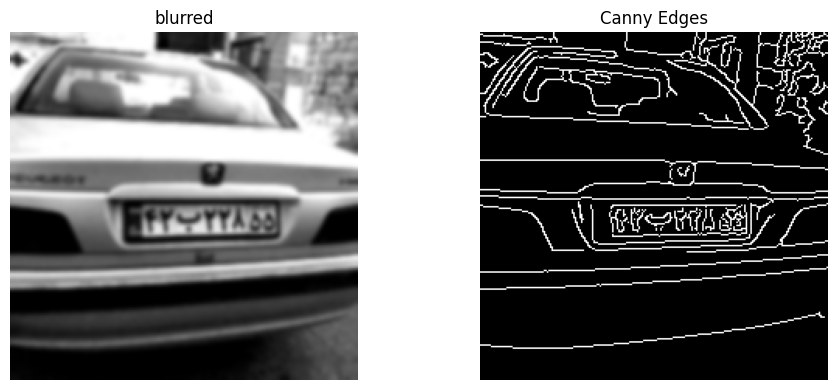

In [57]:
edges = detect_edges(blurred, 20, 200)
plot_two_images(blurred, edges, "blurred", "Canny Edges")

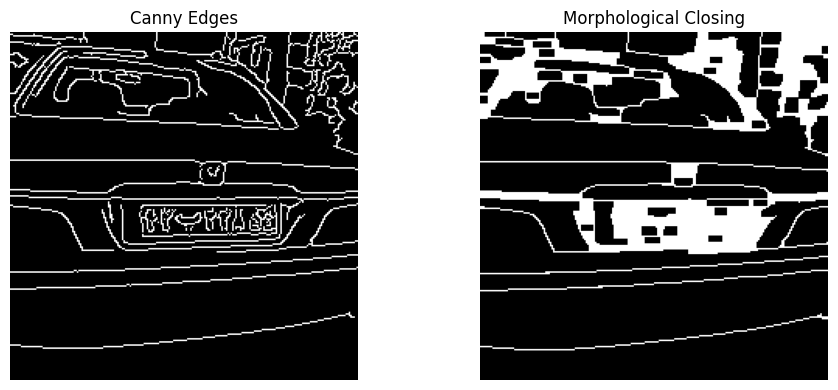

In [58]:
closed = apply_morphology(edges, kernel_size=(8, 4))
plot_two_images(edges, closed, "Canny Edges", "Morphological Closing")

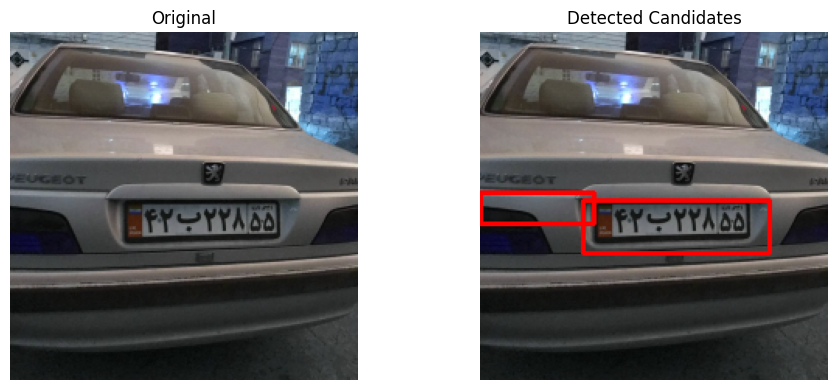

In [59]:
candidates = find_plate_candidates(closed, aspect_ratio_range=(2, 6))
boxed = draw_candidates(original, candidates)
plot_two_images(original, boxed,"Original", "Detected Candidates")

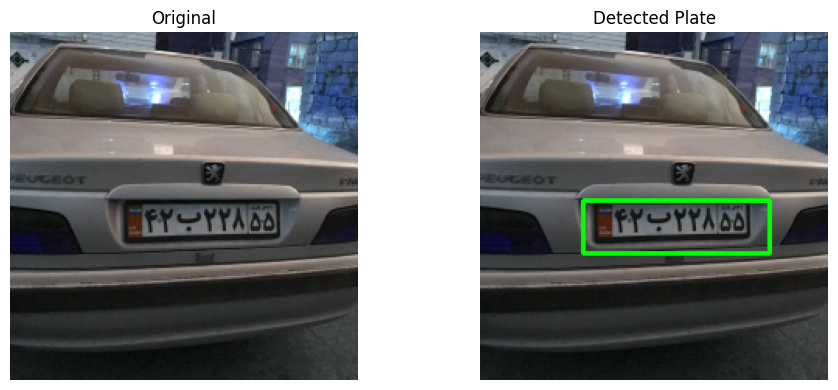

In [68]:
best_candidate = get_centered_candidate(candidates)
image_with_box = draw_candidate_box(original, best_candidate)
plot_two_images(original, image_with_box, "Original", "Detected Plate")

In [ ]:
def final_func_guassian(image_path, visualize=False):
    original = load_image(image_path)
    gray = to_grayscale(original)
    enhanced = linear_contrast_stretch(gray , low_percentile=15, high_percentile=85)
    blurred = apply_gaussian_blur(enhanced, (7,7), 0)
    edges = detect_edges(blurred, 20, 200)
    closed = apply_morphology(edges, kernel_size=(8, 4))
    candidates = find_plate_candidates(closed, aspect_ratio_range=(2, 6))
    boxed = draw_candidates(original, candidates)
    # centered = choose_centered_candidate(candidates)
    centered = get_centered_candidate(candidates)
    best_candidate = get_centered_candidate(candidates)
    if visualize:
        image_with_box = draw_candidate_box(original, best_candidate)
        plot_two_images(original, image_with_box, "Original", "Detected Plate")

    return best_candidate

def upscale_bbox(bbox, original_size=1280, processed_size=224):
    scale = original_size / processed_size
    x, y, w, h = bbox
    return [int(x * scale), int(y * scale), int(w * scale), int(h * scale)]

def crop_and_save_plate(image_path, bbox, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    x, y, w, h = upscale_bbox(bbox)
    cropped = image[y:y+h, x:x+w]

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, cropped)

def process_all_images(input_dir, output_dir):
    for file in os.listdir(input_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_input_path = os.path.join(input_dir, file)
            
            # Resize to 224x224 and run detection
            resized = cv2.resize(cv2.imread(full_input_path), (224, 224))
            temp_path = "temp_resized.jpg"
            cv2.imwrite(temp_path, resized)

            bbox = final_func_guassian(temp_path, visualize=False)
            # print(bbox)

            if bbox is not None:
                output_path = os.path.join(output_dir, file)
                crop_and_save_plate(full_input_path, bbox, output_path)
            else:
                # print(f"No plate found in: {file}")
                pass


current_dir = os.getcwd()
test_dir = os.path.join(current_dir, "test-dataset")
test_dir = os.path.join(test_dir, "Vehicle Plates 1280x1280", "Vehicle Plates 1280x1280")
output_directory = os.path.join(current_dir, "cropped-no-annotation")
process_all_images(test_dir, output_directory)


def candidate_to_xml_bbox(candidate):
    if candidate is None:
        return None

    x, y, w, h = candidate
    xmin = int(x)
    ymin = int(y)
    xmax = int(x + w)
    ymax = int(y + h)
    return (xmin, ymin, xmax, ymax)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    unionArea = float(boxAArea + boxBArea - interArea)
    if unionArea == 0:
        return 0.0
    return interArea / unionArea

def evaluate_detection_gaussian(annotation_txt, image_folder, image_ext=".png"):
    with open(annotation_txt, "r") as f:
        lines = f.readlines()
    gt_boxes = {}
    for line in lines:
        id_part, coords = line.strip().split(":")
        coords = list(map(int, coords.strip().split(",")))
        gt_boxes[int(id_part)] = tuple(coords)  # (xmin, ymin, xmax, ymax)

    ious = []
    total = 0
    matched = 0

    for idx, gt_box in gt_boxes.items():
        image_path = os.path.join(image_folder, f"{idx}{image_ext}")
        original = load_image(image_path)
        gray = to_grayscale(original)
        enhanced = linear_contrast_stretch(gray, 15, 85)
        blurred = apply_gaussian_blur(enhanced, (9,9), 0)
        edges = detect_edges(blurred, 20, 200)
        closed = apply_morphology(edges, kernel_size=(8, 4))
        candidates = find_plate_candidates(closed, aspect_ratio_range=(2, 6))
        best_candidate = get_centered_candidate(candidates)
        pred_box = candidate_to_xml_bbox(best_candidate)

        if pred_box:
            iou = compute_iou(pred_box, gt_box)
            ious.append(iou)
            if iou >= 0.5:
                matched += 1
        else:
            ious.append(0.0)

        total += 1

    avg_iou = sum(ious) / total if total else 0
    print(f"Evaluated {total} images.")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"IoU ≥ 0.5 in {matched}/{total} images ({(matched / total) * 100:.1f}%)")




---

## PHASE2 - test data pre-process and detecting the characters from test

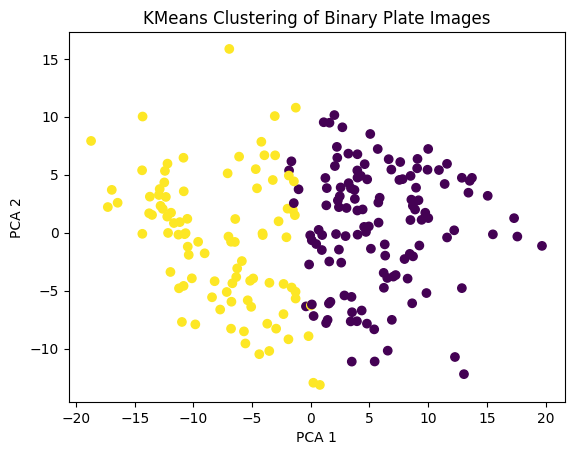

In [82]:
folder_path = 'cropped-annotation'
result_path = 'clusstered-annotation'
image_size = (64, 64)
n_clusters = 2

image_vectors = []
image_files = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, image_size)
        img = img.flatten() / 255.0
        image_vectors.append(img)
        image_files.append(filename)

image_vectors = np.array(image_vectors)

pca = PCA(n_components=50)
reduced_features = pca.fit_transform(image_vectors)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(reduced_features)

if os.path.exists(result_path):
    shutil.rmtree(result_path)
os.makedirs(result_path)

for i in range(n_clusters):
    os.makedirs(os.path.join(result_path, str(i + 1)))

for idx, label in enumerate(labels):
    src = os.path.join(folder_path, image_files[idx])
    dst = os.path.join(result_path, str(label + 1), image_files[idx])
    shutil.copy2(src, dst)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.title('KMeans Clustering of Binary Plate Images')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [94]:
def get_cluster_path():
    current_dir = os.getcwd()
    cluster1 = os.path.join(current_dir, "clusstered", "1")
    cluster2 = os.path.join(current_dir, "clusstered", "2")
    return cluster1, cluster2

def get_output_dir_final(image_num):
    current_dir = os.getcwd()
    output_dir = os.path.join(current_dir, "components_final_merged-annotation", str(image_num))
    return output_dir

def get_path_cropped_clustered(im_num):
    imm = str(im_num) + ".png"
    current_dir = os.getcwd()
    cluster1 = os.path.join(current_dir, "clusstered-annotation", "1", imm)
    cluster2 = os.path.join(current_dir, "clusstered-annotation", "2", imm)
    return cluster1, cluster2

def get_path_cropped(im_num):
    imm = str(im_num) + ".png"
    current_dir = os.getcwd()
    current_dir = os.path.join(current_dir, "cropped-annotation")
    image_path = os.path.join(current_dir, imm)
    return image_path

def binarize_image(image, threshold=127):
    _, binary = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary

def color_masked(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    mask_red1  = cv2.inRange(hsv, lower_red1, upper_red1)

    lower_red2 = np.array([160, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask_red2  = cv2.inRange(hsv, lower_red2, upper_red2)

    mask_red = cv2.bitwise_or(mask_red1, mask_red2)

    # Optional: Limit to left third like before
    spatial_mask = np.zeros_like(mask_red)
    spatial_mask[:, :img.shape[1] // 3] = 255
    mask_red = cv2.bitwise_and(mask_red, spatial_mask)

    contours, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cleaned = img.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 100:
            cv2.rectangle(cleaned, (x, y), (x + w, y + h), (235, 235, 235), thickness=-1)

    border_size = 7
    cleaned = cleaned[
        border_size : -border_size,
        border_size : -border_size
    ]
    return cleaned

def find_connected_components(image, min_area=100, max_area=120, max_width=100, max_height=100, min_width=10, min_height=20, connectivity=8):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=connectivity)

    components = [
        (x, y, w, h)
        for i, (x, y, w, h, area) in enumerate(stats)
        if i != 0 and min_area <= area <= max_area
        and min_width < w < max_width and min_height < h < max_height
        and h/w < 6 and w/h < 6
    ]

    if len(components) >= 8:
        height, width = image.shape
        right_75_start = int(width * 0.3)

        right_components = [comp for comp in components if comp[0] >= right_75_start]

        to_remove = None

        for i, (x1, y1, w1, h1) in enumerate(right_components):
            box1 = (x1, y1, x1 + w1, y1 + h1)
            overlaps = 0
            for j, (x2, y2, w2, h2) in enumerate(right_components):
                if i == j:
                    continue
                box2 = (x2, y2, x2 + w2, y2 + h2)
                ix1 = max(box1[0], box2[0])
                iy1 = max(box1[1], box2[1])
                ix2 = min(box1[2], box2[2])
                iy2 = min(box1[3], box2[3])
                iw = max(0, ix2 - ix1)
                ih = max(0, iy2 - iy1)
                intersection_area = iw * ih
                smaller_area = min(w2 * h2, w1 * h1)
                if intersection_area > 0.5 * smaller_area:
                    overlaps += 1

            if overlaps >= 2:
                to_remove = (x1, y1, w1, h1)
                break

        if to_remove:
            components.remove(to_remove)

    width = image.shape[1]
    left_75_end = int(width * 0.75)
    merged = []
    used = set()

    for i in range(len(components)):
        if i in used:
            continue
        x1, y1, w1, h1 = components[i]
        if x1 >= left_75_end:
            merged.append((x1, y1, w1, h1))
            continue

        box1 = (x1, y1, x1 + w1, y1 + h1)
        did_merge = False

        for j in range(i + 1, len(components)):
            if j in used:
                continue
            x2, y2, w2, h2 = components[j]
            if x2 >= left_75_end:
                continue

            box2 = (x2, y2, x2 + w2, y2 + h2)

            ix1 = max(box1[0], box2[0])
            iy1 = max(box1[1], box2[1])
            ix2 = min(box1[2], box2[2])
            iy2 = min(box1[3], box2[3])
            iw = max(0, ix2 - ix1)
            ih = max(0, iy2 - iy1)
            intersection_area = iw * ih
            smaller_area = min(w1 * h1, w2 * h2)

            if intersection_area > 0.3 * smaller_area:
                # Merge boxes
                x_min = min(x1, x2)
                y_min = min(y1, y2)
                x_max = max(x1 + w1, x2 + w2)
                y_max = max(y1 + h1, y2 + h2)
                merged.append((x_min, y_min, x_max - x_min, y_max - y_min))
                used.update({i, j})
                did_merge = True
                break

        if not did_merge:
            merged.append((x1, y1, w1, h1))

    components = merged

    if len(components) > 8:
        components = sorted(components, key=lambda comp: comp[2] * comp[3], reverse=True)[:8]

    return components

def find_connected_components_less_limited(image, min_area=80):
    """
    Finds connected components in a binary image.
    Returns a list of bounding boxes (x, y, w, h) for each component with area >= min_area.
    Also prints width, height, and area for debugging purposes.
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)
    
    components = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        # print(f"[DEBUG] Component {i}: x={x}, y={y}, width={w}, height={h}, area={area}")
        
        if area >= min_area:
            components.append((x, y, w, h))
    
    return components


def boxes_overlap(box1, box2):
    """
    Check if two boxes overlap.
    Each box: [x1, y1, x2, y2]
    """
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    return x_right > x_left and y_bottom > y_top

def draw_bounding_boxes(image, components, color=(0, 255, 0), thickness=2):
    """
    Draws bounding boxes around connected components on a copy of the input image.
    Expects the image to be in grayscale or color.
    """
    # Convert grayscale to color for drawing if needed
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    output = image.copy()
    for (x, y, w, h) in components:
        cv2.rectangle(output, (x, y), (x + w, y + h), color, thickness)
    
    return output


def deskew_plate_by_horizontal_edge(img: np.ndarray, canny_thresh=(50, 150), max_angle=30) -> np.ndarray:
    """
    Detects multiple horizontal lines in the image and uses their average angle
    to rotate the entire image. Avoids cropping or perspective warping.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, *canny_thresh)

    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=80,
                            minLineLength=img.shape[1] // 5, maxLineGap=30)

    if lines is None:
        raise RuntimeError("No lines detected – adjust thresholds.")

    angles = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        dx, dy = x2 - x1, y2 - y1
        angle = np.degrees(np.arctan2(dy, dx))
        
        if abs(angle) < max_angle:
            angles.append(angle)

    if not angles:
        raise RuntimeError("No near-horizontal lines found – try increasing max_angle.")

    avg_angle = np.median(angles)

    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, avg_angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    return cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)

def crop_components_to_images_full_version(
    image_path,
    binary_path,
    output_dir, 
    margin=8,
    min_area=83, max_area=400, 
    max_width=100, max_height=100, 
    min_width=8, min_height=18, 
    connectivity=8
    ):

    binary_img = cv2.imread(binary_path, cv2.IMREAD_GRAYSCALE)
    if binary_img is None:
        # raise FileNotFoundError(f"Cannot read image at path: {binary_path}")
        return

    os.makedirs(output_dir, exist_ok=True)
    
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at: {image_path}")

    try:
        img = deskew_plate_by_horizontal_edge(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    except RuntimeError as e:
        print(f"[Warning] Deskew failed: {e}")

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_blue = np.array([100, 80, 50])
    upper_blue = np.array([135, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    spatial_mask = np.zeros_like(mask_blue)
    spatial_mask[:, :img.shape[1] // 3] = 255
    mask_blue = cv2.bitwise_and(mask_blue, spatial_mask)

    contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cleaned = img.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 100:
            cv2.rectangle(cleaned, (x, y), (x + w, y + h), (235, 235, 235), thickness=-1)

    border_size = 10
    cleaned = cleaned[
        border_size : -border_size,
        border_size : -border_size
    ]

    gray = cv2.cvtColor(cleaned, cv2.COLOR_BGR2GRAY)

    low = np.percentile(gray, 35)
    high = np.percentile(gray, 40)
    stretched = np.clip(gray, low, high)
    enhanced = cv2.normalize(stretched, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    img = blurred

    height, width = img.shape
    crop_x = int(width * 0.10)
    img = img[:, crop_x:]


    height, width = binary_img.shape
    crop_x = int(width * 0.10)
    binary_img = binary_img[:, crop_x:]

    components = find_connected_components(
        binary_img,
        min_area=min_area,
        max_area=max_area,
        max_width=max_width,
        max_height=max_height,
        min_width=min_width,
        min_height=min_height,
        connectivity=connectivity
    )
    components.sort(key=lambda box: box[0])
    height, width = img.shape

    for idx, (x, y, w, h) in enumerate(components):
        x_start = max(x - (margin), 0)
        y_start = max(y - margin//2, 0)
        x_end = min(x + w + (margin//2), width)
        y_end = min(y + h + (margin+1), height)

        cropped = img[y_start:y_end, x_start:x_end]
        h_c, w_c = cropped.shape[:2]
        scale = 110 / max(h_c, w_c)
        new_w, new_h = int(w_c * scale), int(h_c * scale)

        resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        if len(resized.shape) == 2:
            padded = np.full((110, 110), 255, dtype=np.uint8)
        else:
            padded = np.full((110, 110, 3), (255, 255, 255), dtype=np.uint8)

        x_offset = (110 - new_w) // 2
        y_offset = (110 - new_h) // 2
        padded[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

        output_path = os.path.join(output_dir, f"component_{idx + 1}.png")
        cv2.imwrite(output_path, padded)


for img in range(1, 218):
    image_path= get_path_cropped(img)
    output_dir = get_output_dir_final(img)
    cluster_path1, cluster_path2 = get_path_cropped_clustered(img)
    crop_components_to_images_full_version(image_path, cluster_path1, output_dir, margin=4)
    crop_components_to_images_full_version(image_path, cluster_path2, output_dir, margin=4,
                                           min_area=80, max_area=420, max_width=110, max_height=110, min_width=7, min_height=19)

---

## PHASE2 - train data pre-process and 

In [127]:
def shear_image(image, shear_x=0.3, shear_y=0.3, fill_color=(255, 255, 255)):
    width, height = image.size
    matrix = (1, shear_x, 0, shear_y, 1, 0)
    new_width = int(width + abs(shear_x) * height)
    new_height = int(height + abs(shear_y) * width)

    return image.transform(
        (new_width, new_height),
        Image.AFFINE,
        matrix,
        fillcolor=fill_color
    )

def process_shear_in_directory(directory_path, shear_x=0.2, shear_y=0.2, visualization=False):
    def extract_number(filename):
        match = re.match(r"(\d+)", filename)
        return int(match.group(1)) if match else float('inf')

    filenames = sorted(
        [f for f in os.listdir(directory_path) if f.lower().endswith((".jpg", ".png"))],
        key=extract_number
    )

    for filename in filenames:
        img_path = os.path.join(directory_path, filename)
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue

        sheared = shear_image(img, shear_x=shear_x, shear_y=shear_y)

        base_name, ext = os.path.splitext(filename)
        sheared_name = f"{base_name}_shearx{shear_x:+.1f}_sheary{shear_y:+.1f}{ext}"
        sheared_path = os.path.join(directory_path, sheared_name)
        sheared.save(sheared_path)

        if visualization:
            plot_two_images(img, sheared, "Original", "Sheared")

def shear_all_subfolders(parent_dir, shear_x=0.2, shear_y=0.2):
    for entry in os.listdir(parent_dir):
        folder_path = os.path.join(parent_dir, entry)
        if os.path.isdir(folder_path):
            print(f"Processing folder: {folder_path}")
            process_shear_in_directory(folder_path, shear_x=shear_x, shear_y=shear_y)

def down_sample(image, width, height):
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy = image.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_salt_pepper_noise(image, amount=0.02, salt_vs_pepper=0.5):
    noisy = image.copy()
    total_pixels = image.size
    num_salt = int(amount * total_pixels * salt_vs_pepper)
    num_pepper = int(amount * total_pixels * (1.0 - salt_vs_pepper))

    # Salt (white)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy[tuple(coords)] = 255

    # Pepper (black)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy[tuple(coords)] = 0

    return noisy

def add_speckle_noise(image):
    noise = np.random.randn(*image.shape)
    noisy = image + image * noise
    return np.clip(noisy, 0, 255).astype(np.uint8)


def augment_with_noise(image, modes=("gaussian", "salt_pepper", "speckle", None)):
    """
    Returns a *new* image that is either unchanged or has one kind of noise.
    """
    mode = random.choice(modes)
    if mode == "gaussian":
        return add_gaussian_noise(image, std=15)
    elif mode == "salt_pepper":
        return add_salt_pepper_noise(image, amount=0.02)
    elif mode == "speckle":
        return add_speckle_noise(image)
    else:
        return image.copy()

def main_train_prepare(img_path, visualization=False):
    img = load_image(img_path)
    gray = to_grayscale(img)
    blurred = apply_gaussian_blur(gray, kernel_size=(3, 3))
    cropped = crop_character(gray)
    filtered = apply_median_filter(cropped, kernel_size=3)
    blurred = apply_gaussian_blur(filtered, kernel_size=(7, 7))
        # edges = detect_edges(blurred, 20, 200)
    edges_noisy = add_gaussian_noise(blurred, std=15)
    dwn_sampled = down_sample(edges_noisy, 30, 30)

    if visualization:
        plot_two_images(original, edges, "original", "output")

    return dwn_sampled

def crop_character(image, output_size=(110, 110), threshold=200):
    """
    Crops a grayscale NumPy image and resizes it to fixed size with centered padding.
    Assumes `image` is a NumPy array in grayscale.
    """
    if len(image.shape) != 2:
        raise ValueError("Input must be a grayscale image (2D array)")

    # Create mask for dark pixels
    mask = image < threshold
    if not np.any(mask):
        return cv2.resize(image, output_size, interpolation=cv2.INTER_AREA)

    # Get bounding box
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1  # exclusive

    cropped = image[y0:y1, x0:x1]

    # Resize cropped region with aspect ratio preserved
    h, w = cropped.shape
    scale = min((output_size[1] - 4) / w, (output_size[0] - 4) / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create blank white image and paste resized in center
    final = np.full(output_size, 255, dtype=np.uint8)
    offset_x = (output_size[1] - new_w) // 2
    offset_y = (output_size[0] - new_h) // 2
    final[offset_y:offset_y + new_h, offset_x:offset_x + new_w] = resized

    return final

def crop_images_in_directory(directory_path, output_dir, visualization=False):
    """
    Applies main_crop() to all .jpg images in a directory and saves the results.
    Assumes main_crop() returns a NumPy array (grayscale).
    """
    os.makedirs(output_dir, exist_ok=True)

    # print("main_crop_called")
    def extract_number(filename):
        match = re.match(r"(\d+)", filename)
        return int(match.group(1)) if match else float('inf')

    filenames = sorted(
        [f for f in os.listdir(directory_path) if f.lower().endswith(".jpg")],
        key=extract_number
    )

    for i, filename in enumerate(filenames, start=1):
        img_path = os.path.join(directory_path, filename)

        try:
            processed = main_train_prepare(img_path)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

        # Convert to PIL Image (grayscale mode) and save
        save_path = os.path.join(output_dir, f"{i}.jpg")
        Image.fromarray(processed.astype('uint8'), mode='L').save(save_path)

        # Optional: show comparison
        if visualization:
            original = cv2.imread(img_path)
            original_gray = to_grayscale(original)
            plot_two_images(original_gray, processed, "Original", "Processed")

def crop_images_in_all_subfolders(parent_dataset_dir, output_root_dir):
    for folder_name in os.listdir(parent_dataset_dir):
        folder_path = os.path.join(parent_dataset_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue  # Skip files

        # Create corresponding output directory
        output_dir = os.path.join(output_root_dir, folder_name)
        os.makedirs(output_dir, exist_ok=True)

        # Call your crop function here
        crop_images_in_directory(folder_path, output_dir)
        # print(f"Processed: {folder_name}")

current_dir = os.getcwd()
dataset_root = os.path.join(current_dir, "train-dataset")
output_root = os.path.join(current_dir, "train-dataset-prepaired")
shear_all_subfolders(dataset_root, 0.1, 0.1)
shear_all_subfolders(dataset_root, 0.1, -0.1)
crop_images_in_all_subfolders(dataset_root, output_root)

Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\1-alef
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\10-d
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\11-zal
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\12-r
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\13-z
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\14-zh
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\15-sin
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\16-shin
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\17-sad
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\18-zad
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\19-t-long
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\2-b
Processing folder: C:\Users\user\Desktop\CI-PROJECT2\train-dataset\20-z-long
Processing folder: C:\Users\user\Desktop\

---

## PHASE3 - 